In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [5]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [6]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Locate TTC stations

## Grab station url from TTC website
<img src="../data/image/2022-11-11-11-43-58.png">

In [7]:
# allowed under https://www.ttc.ca/robots.txt
hdr = {'User-Agent': "Mozilla/5.0"}
routes_url = 'https://www.ttc.ca/routes-and-schedules#/'
soup = BeautifulSoup(requests.get(routes_url, headers=hdr).text)
soup_extract = soup.find_all(attrs={'data-react-component':'Schedule'})[0]['data-react-props']
json_data = json.loads(soup_extract)['stations']
ttc_df = pd.DataFrame(json_data)[['Url']]
ttc_df.rename(columns={'Url':'url'}, inplace=True)

In [8]:
ttc_df['station'] = ttc_df['url'].apply(lambda x: 
    x.split('https://www.ttc.ca/subway-stations/')[1].
    replace('-station', ' ').
    replace('-', ' ').
    strip())

In [9]:
ttc_df.head()

,url,station
0,https://www.ttc.ca/subway-stations/bathurst-st...,bathurst
1,https://www.ttc.ca/subway-stations/bay-station,bay
2,https://www.ttc.ca/subway-stations/bayview-sta...,bayview
3,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion
4,https://www.ttc.ca/subway-stations/bloor-yonge...,bloor yonge


## Get line-station mapping from Wikipedia
<img src="../data/image/2022-11-11-11-41-14.png">

In [10]:
# get the list of subway stations mapping with line from wikipedia
# https://en.wikipedia.org/robots.txt
wiki_station = []
wiki_line = []
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Toronto_subway_stations'
soup = BeautifulSoup(requests.get(wiki_url, headers=hdr).text)
# 4 tables in wiki website, with the 2nd one specifying existing subway stations
# 4th one will be the stations under construction
table = soup.find_all('tbody')[1] 
for tr in table.find_all('tr'):
    if tr.find('th').get('scope') == 'row':
        wiki_station.append(re.sub(u"\u2013", "-", 
                                   tr.find('th').text).
                            strip('\n').
                            strip().
                            lower().
                            replace('.', '').
                            replace("'", '').
                            replace("-", ' '))
        wiki_line.append(re.sub(u"\u2013", "-",tr.find('td').find('a').get('title')))
wiki_df = pd.DataFrame({'station':wiki_station, 'line':wiki_line})
# add stop order in each line
wiki_df['order'] = wiki_df.groupby('line').cumcount()
wiki_df.head()

,station,line,order
0,finch,Line 1 Yonge-University,0
1,north york centre,Line 1 Yonge-University,1
2,sheppard yonge,Line 1 Yonge-University,2
3,york mills,Line 1 Yonge-University,3
4,lawrence,Line 1 Yonge-University,4


In [11]:
# check for mismatch between wiki and ttc
list(set(ttc_df['station']).symmetric_difference(set(wiki_df['station'])))

['vaughan metropolitan centre', 'vaughan']

In [12]:
# fix the entry
wiki_df.loc[wiki_df.station == 'vaughan', 'station'] = 'vaughan metropolitan centre'

In [13]:
stations_df = ttc_df.merge(wiki_df, how='outer', on='station')
stations_df = stations_df.sort_values(by=['line', 'order']).reset_index(drop=True)
stations_df.head()

,url,station,line,order
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4


In [14]:
stations_df.isna().sum()

url        0
station    0
line       0
order      0
dtype: int64

## Longitude and Latitude for each station

In [15]:
# latitude and longitude of each station from Google Map
station_list = pd.read_csv('../data/raw/station_list.csv').values.tolist()

In [16]:
stations_df['longitude'] = [x[1] for x in station_list]
stations_df['latitude'] = [x[0] for x in station_list]

In [17]:
stations_df

,url,station,line,order,longitude,latitude
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387
...,...,...,...,...,...,...
70,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931
71,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874
72,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092
73,https://www.ttc.ca/subway-stations/leslie-station,leslie,Line 4 Sheppard,2,-79.364835,43.771296


In [18]:
stations_df.isna().sum()

url          0
station      0
line         0
order        0
longitude    0
latitude     0
dtype: int64

## Add geometry points

In [19]:
stations_df['geometry'] = stations_df.apply(lambda x: 
    shapely.geometry.Point(x['longitude'], x['latitude']), 
    axis=1)

In [20]:
stations_point = gpd.GeoDataFrame(stations_df, 
                                crs='epsg:' + str(epsg_3d), 
                                geometry='geometry')
print(type(stations_point))
stations_point.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,url,station,line,order,longitude,latitude,geometry
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,POINT (-79.41502 43.78143)
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,POINT (-79.41302 43.76877)
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,POINT (-79.41190 43.76203)
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,POINT (-79.40649 43.74487)
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,POINT (-79.40249 43.72539)


In [21]:
stations_point.line.unique()

array(['Line 1 Yonge-University', 'Line 2 Bloor-Danforth',
       'Line 3 Scarborough', 'Line 4 Sheppard'], dtype=object)

Text(0.5, 1.0, 'TTC Subway Stations')

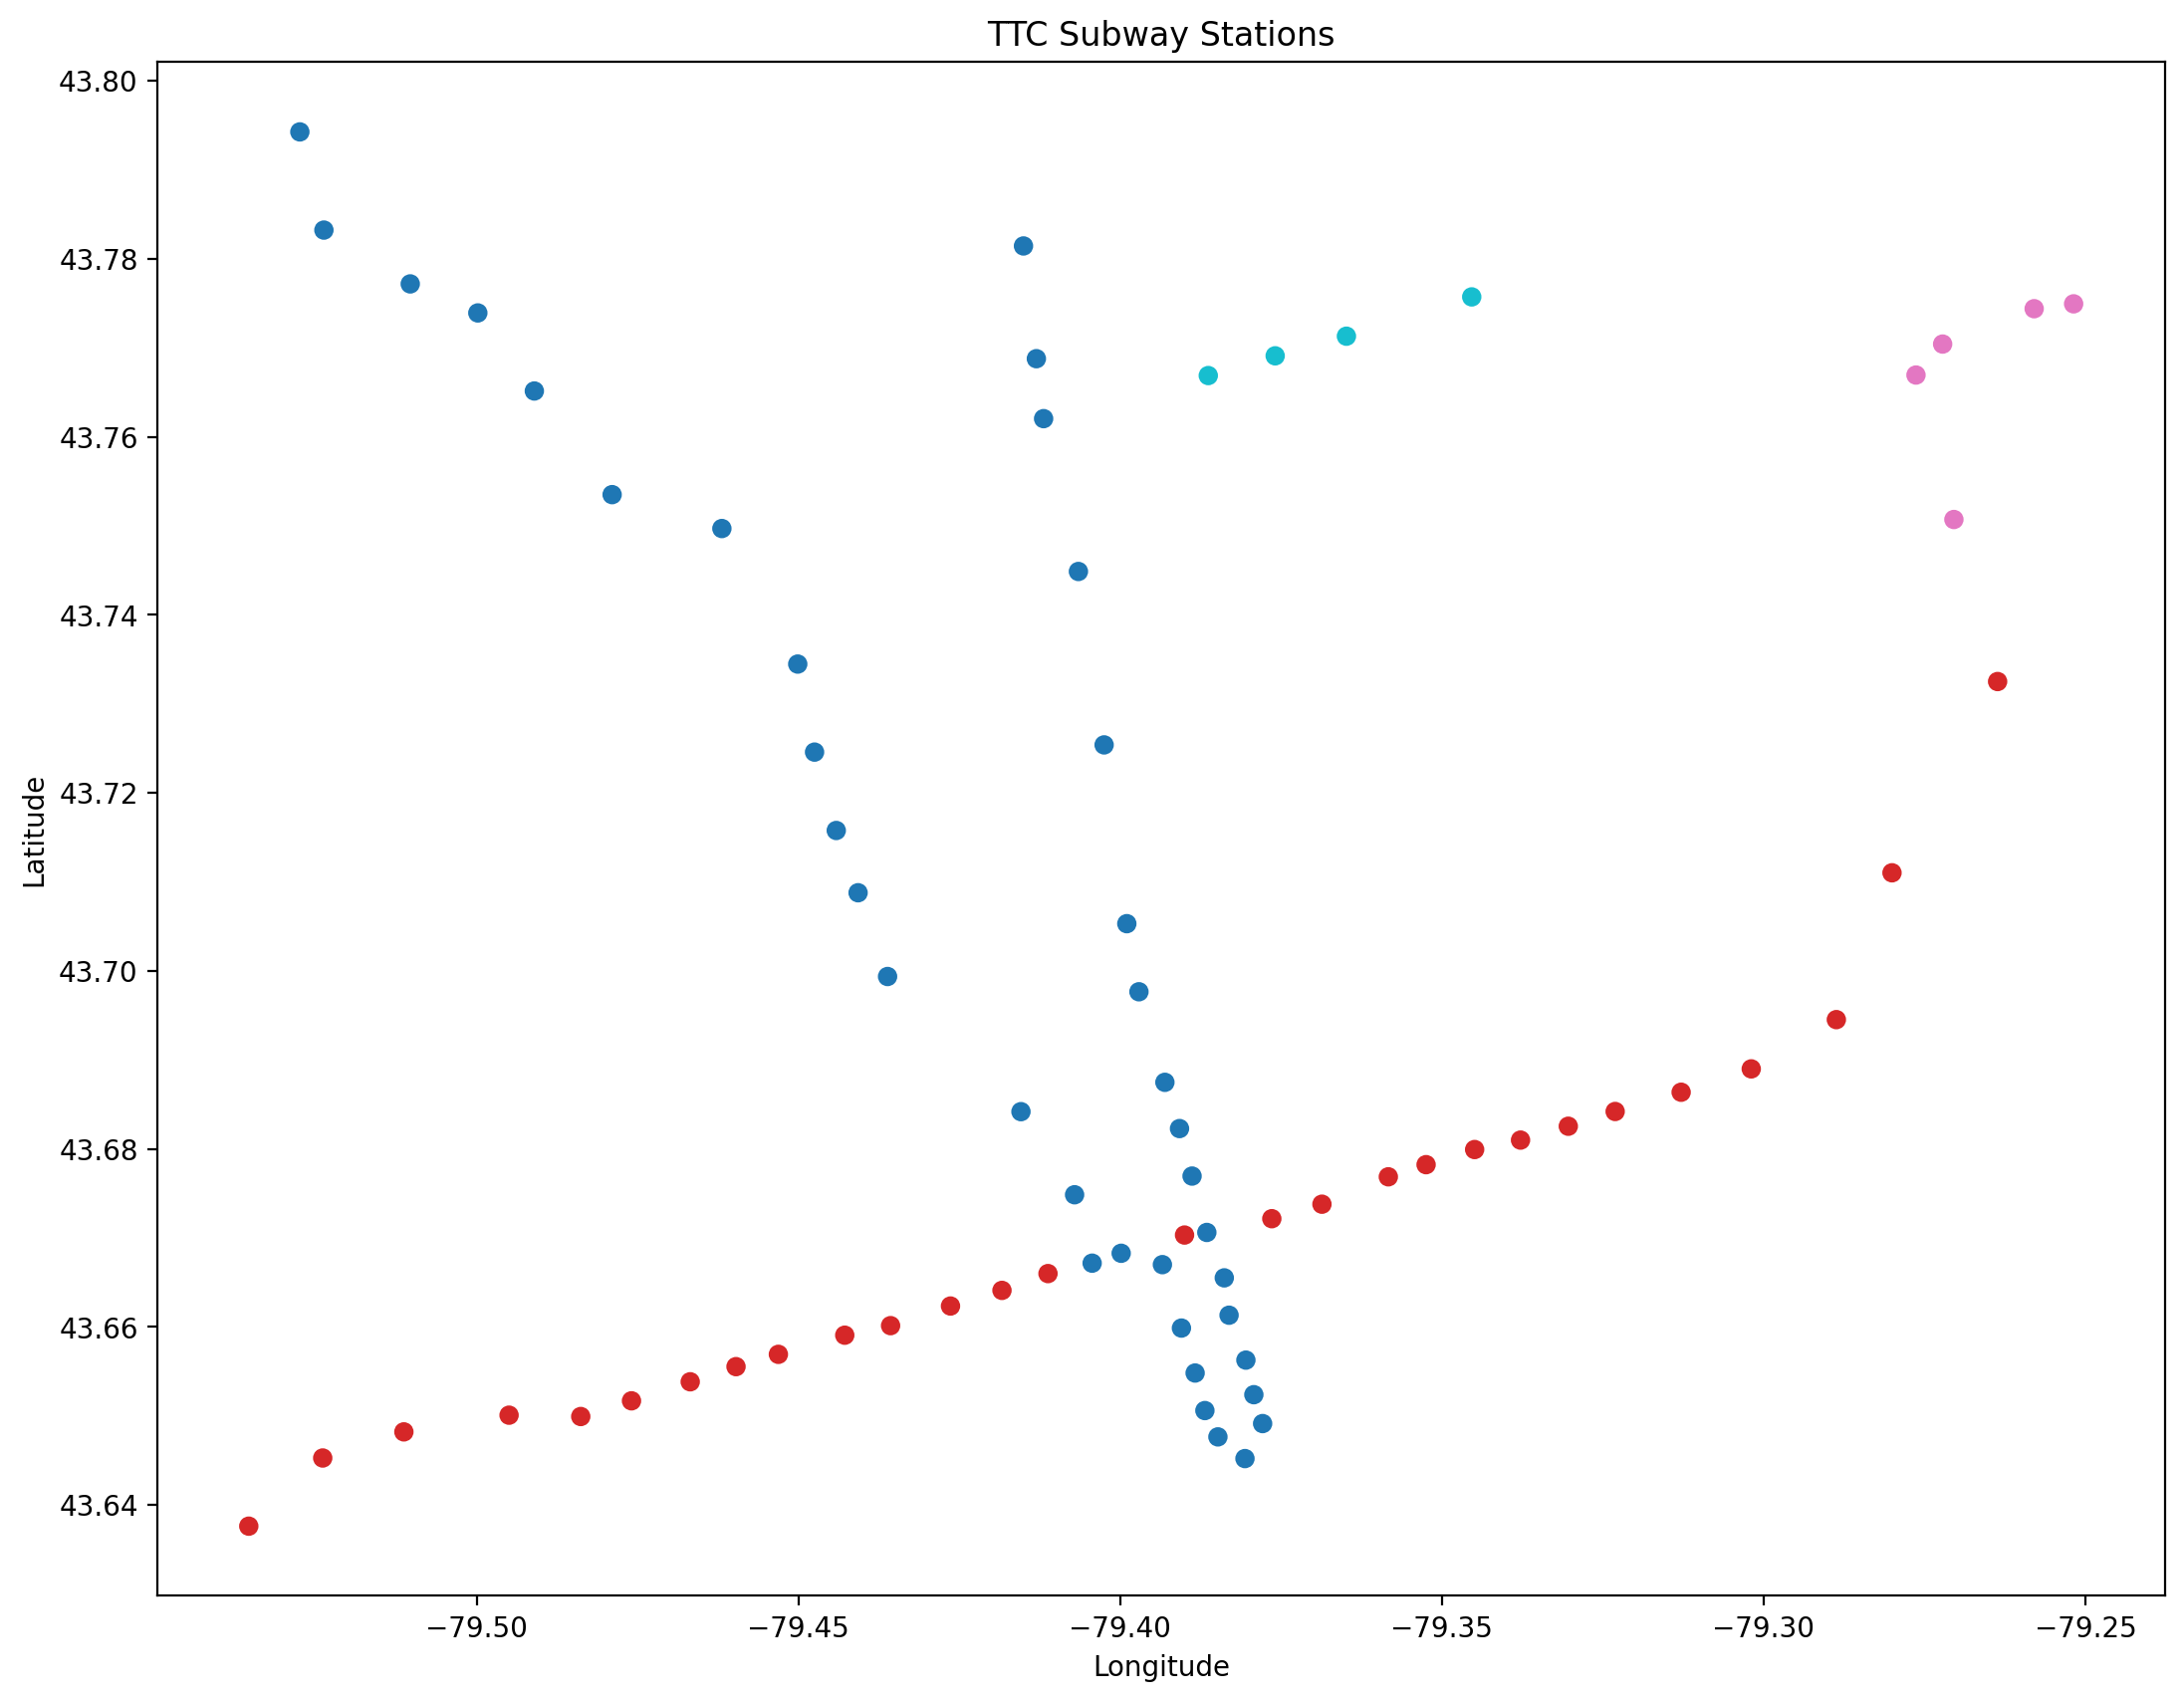

In [22]:
stations_point.plot(column = 'line')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('TTC Subway Stations')

## Distance between consecutive stations and any stations

In [23]:
# convert to projected coordinate system
stations_point = stations_point.to_crs(epsg=epsg_2d)
distance = []
for line in stations_point.line.unique():
    # get distance between 2 consecutive stations within a subway line in km
    for i in range((stations_point[stations_point['line'] == line].shape[0])-1):
        distance.append((stations_point[stations_point['line'] == line].geometry.iloc[i].distance(stations_point[stations_point['line'] == line].geometry.iloc[i+1]))/10**3)

stations_point = stations_point.to_crs(epsg=epsg_3d)

In [24]:
# check distance calculation
i = 20
coords_1 = [stations_point['latitude'][i],stations_point['longitude'][i]]
coords_2 = [stations_point['latitude'][i+1],stations_point['longitude'][i+1]]

print(coords_1)
print(coords_2)
# google map shows 0.82644 km
print(distance[i], "km")
print(geopy.distance.distance(coords_1, coords_2).km, "km")

[43.6598804, -79.3904768]
[43.6670059, -79.3934342]
0.8266757683990448 km
0.8268393690333379 km


Distance between consecutive ttc stations
Average: 1.00 km
Minimum: 0.37 km between st andrew station and osgoode station
Median: 0.86 km between eglinton station and davisville station
Maximum: 2.73 km between victoria park station and warden station


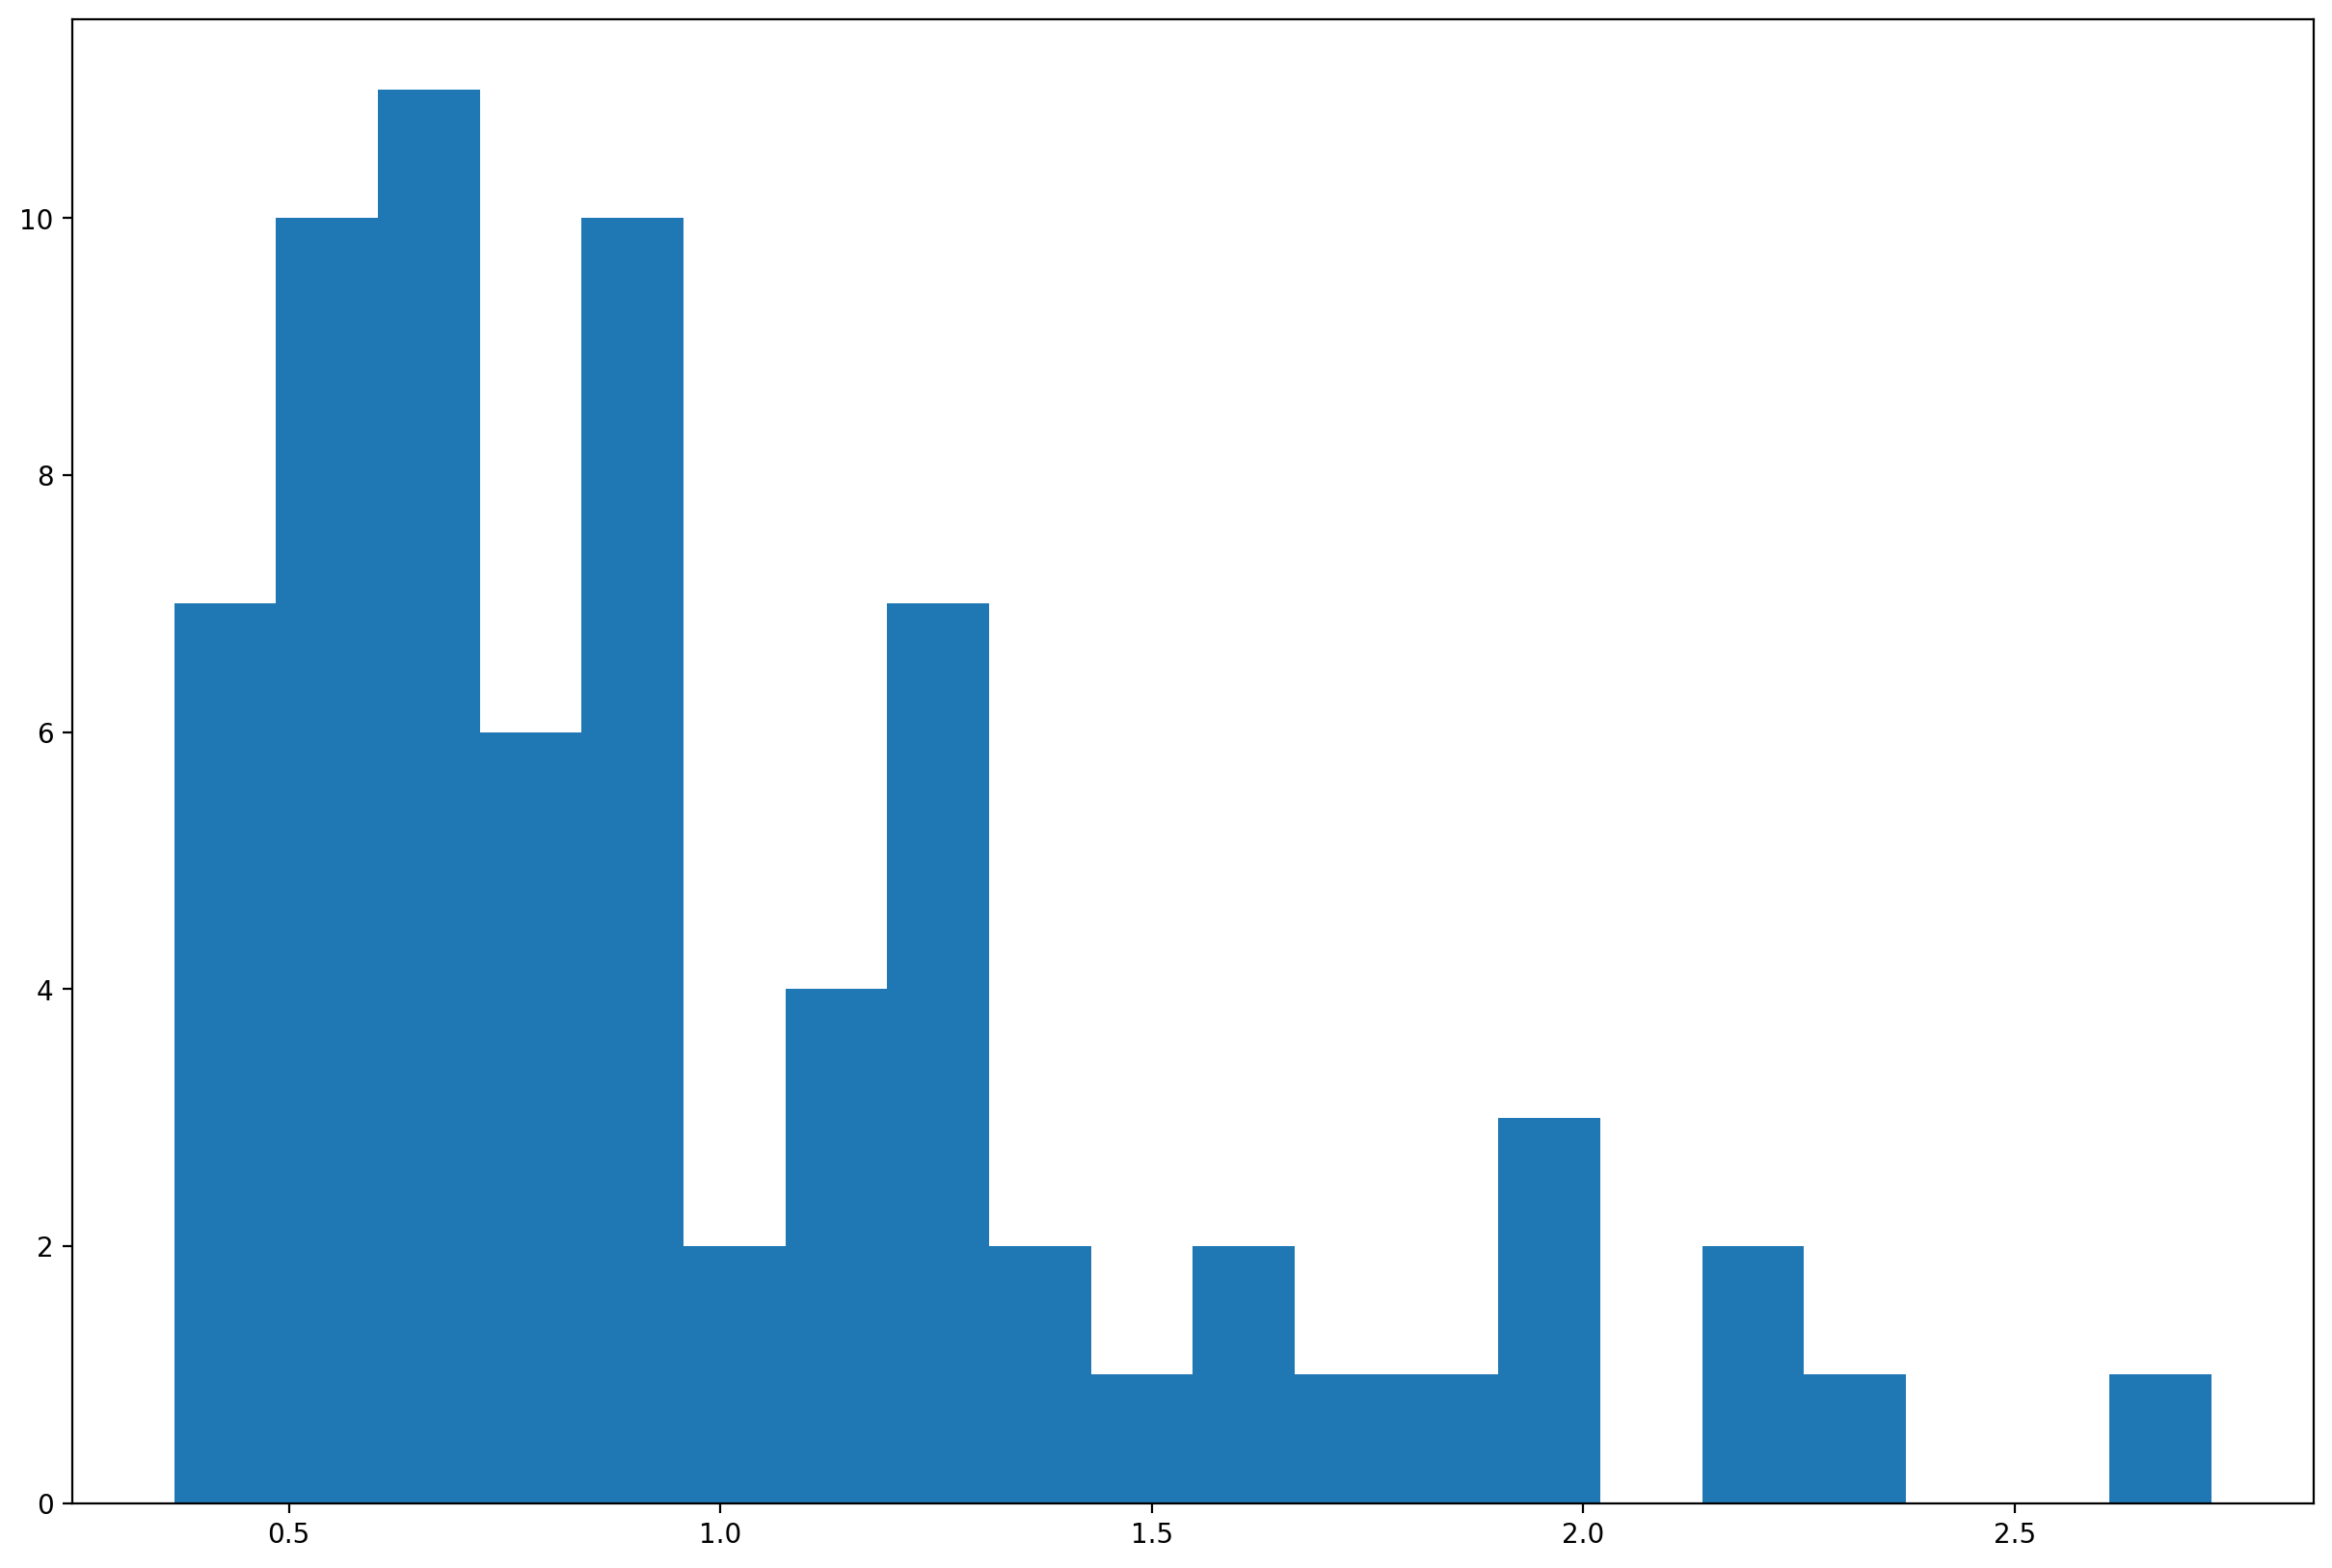

In [25]:
print("Distance between consecutive ttc stations")
plt.hist(distance, bins=20)
print(f"Average: {np.mean(distance):0.2f} km")
min_distance_loc = distance.index(np.min(distance))
print(f"Minimum: {np.min(distance):0.2f} km between {stations_point['station'][min_distance_loc]} station and {stations_point['station'][min_distance_loc+1]} station")
median_distance_loc = distance.index(np.median(distance))
print(f"Median: {np.median(distance):0.2f} km between {stations_point['station'][median_distance_loc]} station and {stations_point['station'][median_distance_loc+1]} station")
max_distance_loc = distance.index(np.max(distance))
print(f"Maximum: {np.max(distance):0.2f} km between {stations_point['station'][max_distance_loc]} station and {stations_point['station'][max_distance_loc+1]} station")


In [26]:
# since subway lines can overlap, there may be adjacent stations that are at a distance that is smaller  
# than the minimum distance between 2 consecutive stations

# convert to projected coordinate system
stations_point = stations_point.to_crs(epsg=epsg_2d)
min_distance = 5
for x in itertools.combinations(stations_point.index, 2):
    # get distance between any 2 stations
    all_distance = (stations_point.geometry.iloc[x[0]].distance(stations_point.geometry.iloc[x[1]]))/10**3
    if all_distance < min_distance:
        min_distance = all_distance
        min_a = stations_point.station.iloc[x[0]]
        min_b = stations_point.station.iloc[x[1]]

stations_point = stations_point.to_crs(epsg=epsg_3d)

print("Distance between any 2 ttc stations")
print(f"Minimum: {min_distance:0.2f} km between {min_a} station and {min_b} station")

Distance between any 2 ttc stations
Minimum: 0.28 km between bloor yonge station and bay station


## Define area around subway stations

In [27]:
# half of average distance between 2 stations
np.median(distance) / 2

0.431565530550326

In [28]:
# define radius around each subway station in km
radius = 0.4 

def create_area(df, r):
    # convert radius in km to m
    # set resolution to 100 to mimic a circle
    return df.to_crs(epsg=epsg_2d).buffer(r*10**3, resolution=1000).to_crs(epsg=epsg_3d)


In [29]:
stations_point = stations_point.to_crs(epsg=epsg_2d)

# 64-sided polygon so not exactly a circle
print(f"Area of defined area around subway station: {(stations_point['geometry'].iloc[0].buffer(radius*10**3, resolution = 100).area)/10**6:0.4f} km^2")
# Check the area vs that of a circle
print(f"Check: {np.pi*radius**2:0.4f}")

stations_point = stations_point.to_crs(epsg=epsg_3d)

Area of defined area around subway station: 0.5026 km^2
Check: 0.5027


In [30]:
stations_area = stations_point.copy(deep=True)
stations_area['geometry'] = create_area(stations_point, radius)

stations_area.head()

,url,station,line,order,longitude,latitude,geometry
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,"POLYGON ((-79.41005 43.78136, -79.41006 43.781..."
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,"POLYGON ((-79.40805 43.76870, -79.40805 43.768..."
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,"POLYGON ((-79.40693 43.76197, -79.40693 43.761..."
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,"POLYGON ((-79.40152 43.74480, -79.40152 43.744..."
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,"POLYGON ((-79.39753 43.72532, -79.39753 43.725..."


Text(412.3449881799721, 0.5, 'Latitude')

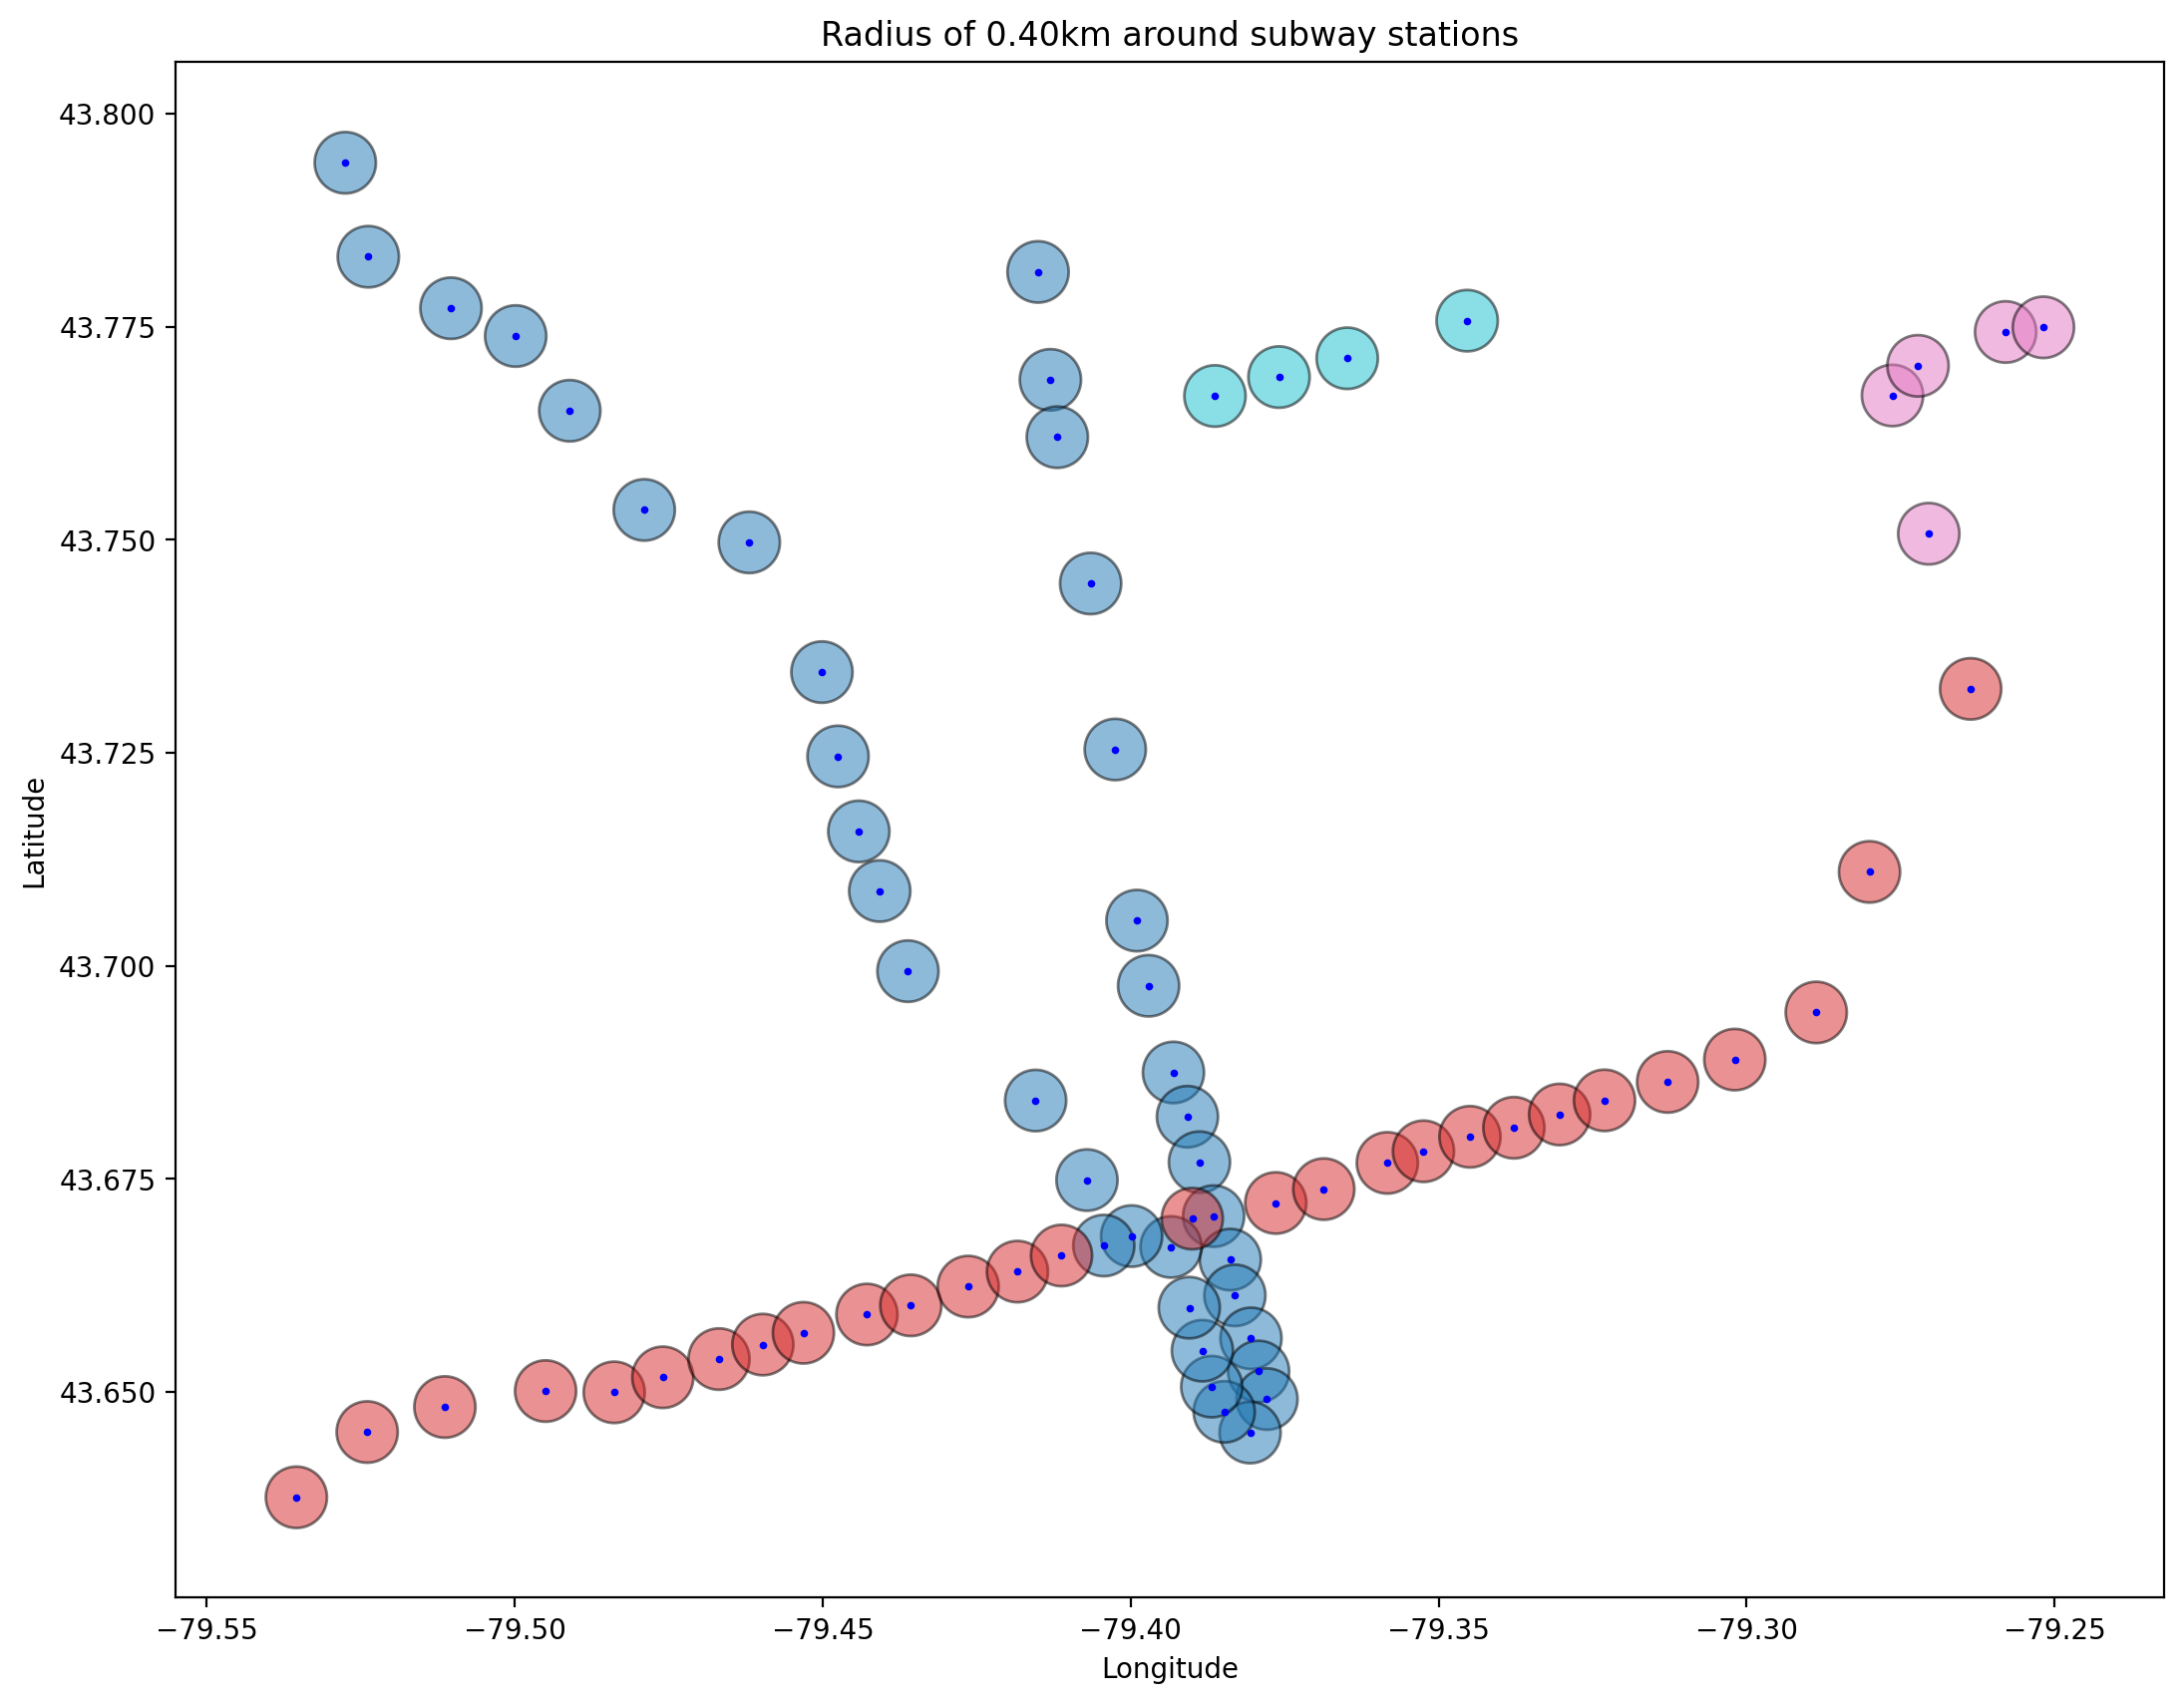

In [32]:
ax = stations_area.plot(column = 'line', edgecolor = 'black', alpha = 0.5)
stations_point.plot(ax=ax, color = 'blue', markersize = 3)
plt.title(f'Radius of {radius:0.2f}km around subway stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [33]:
# output files to data/processed folder
stations_point.to_file('../data/processed/stations_point.geojson', driver='GeoJSON')
stations_area.to_file('../data/processed/stations_area.geojson', driver='GeoJSON')

# Commute time / distance

In [34]:
# from subway stations to RBC WaterPark Place
destination = [43.6410141546389, -79.37876664082673]
commute_time = ['46 min',
                '41 min',
                '40 min',
                '37 min',
                '34 min',
                '30 min',
                '28 min',
                '26 min',
                '25 min',
                '23 min',
                '14 min',
                '13 min',
                '11 min',
                '10 min',
                '16 min',
                '14 min',
                '12 min',
                '11 min',
                '10 min',
                '9 min',
                '6 min',
                '9 min',
                '10 min',
                '12 min',
                '13 min',
                '26 min',
                '21 min',
                '22 min',
                '23 min',
                '25 min',
                '28 min',
                '31 min',
                '34 min',
                '36 min',
                '38 min',
                '41 min',
                '43 min',
                '44 min',
                '33 min',
                '31 min',
                '29 min',
                '27 min',
                '25 min',
                '24 min',
                '23 min',
                '21 min',
                '22 min',
                '19 min',
                '18 min',
                '16 min',
                '15 min',
                '7 min',
                '13 min',
                '5 min',
                '21 min',
                '18 min',
                '19 min',
                '21 min',
                '22 min',
                '35 min',
                '24 min',
                '25 min',
                '27 min',
                '29 min',
                '32 min',
                '36 min',
                '48 min',
                '48 min',
                '49 min',
                '51 min',
                '52 min',
                '48 min',
                '49 min',
                '58 min',
                '52 min']

In [35]:
commute_time = [int(re.search(r'\d+', x).group()) for x in commute_time]

In [36]:
stations_area['commute_time'] = commute_time

In [37]:
stations_area

,url,station,line,order,longitude,latitude,geometry,commute_time
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,"POLYGON ((-79.41005 43.78136, -79.41006 43.781...",46
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,"POLYGON ((-79.40805 43.76870, -79.40805 43.768...",41
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,"POLYGON ((-79.40693 43.76197, -79.40693 43.761...",40
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,"POLYGON ((-79.40152 43.74480, -79.40152 43.744...",37
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,"POLYGON ((-79.39753 43.72532, -79.39753 43.725...",34
...,...,...,...,...,...,...,...,...
70,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931,"POLYGON ((-79.24685 43.77485, -79.24685 43.774...",52
71,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874,"POLYGON ((-79.38134 43.76680, -79.38134 43.766...",48
72,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092,"POLYGON ((-79.37094 43.76902, -79.37094 43.769...",49
73,https://www.ttc.ca/subway-stations/leslie-station,leslie,Line 4 Sheppard,2,-79.364835,43.771296,"POLYGON ((-79.35987 43.77122, -79.35987 43.771...",58


<Axes: >

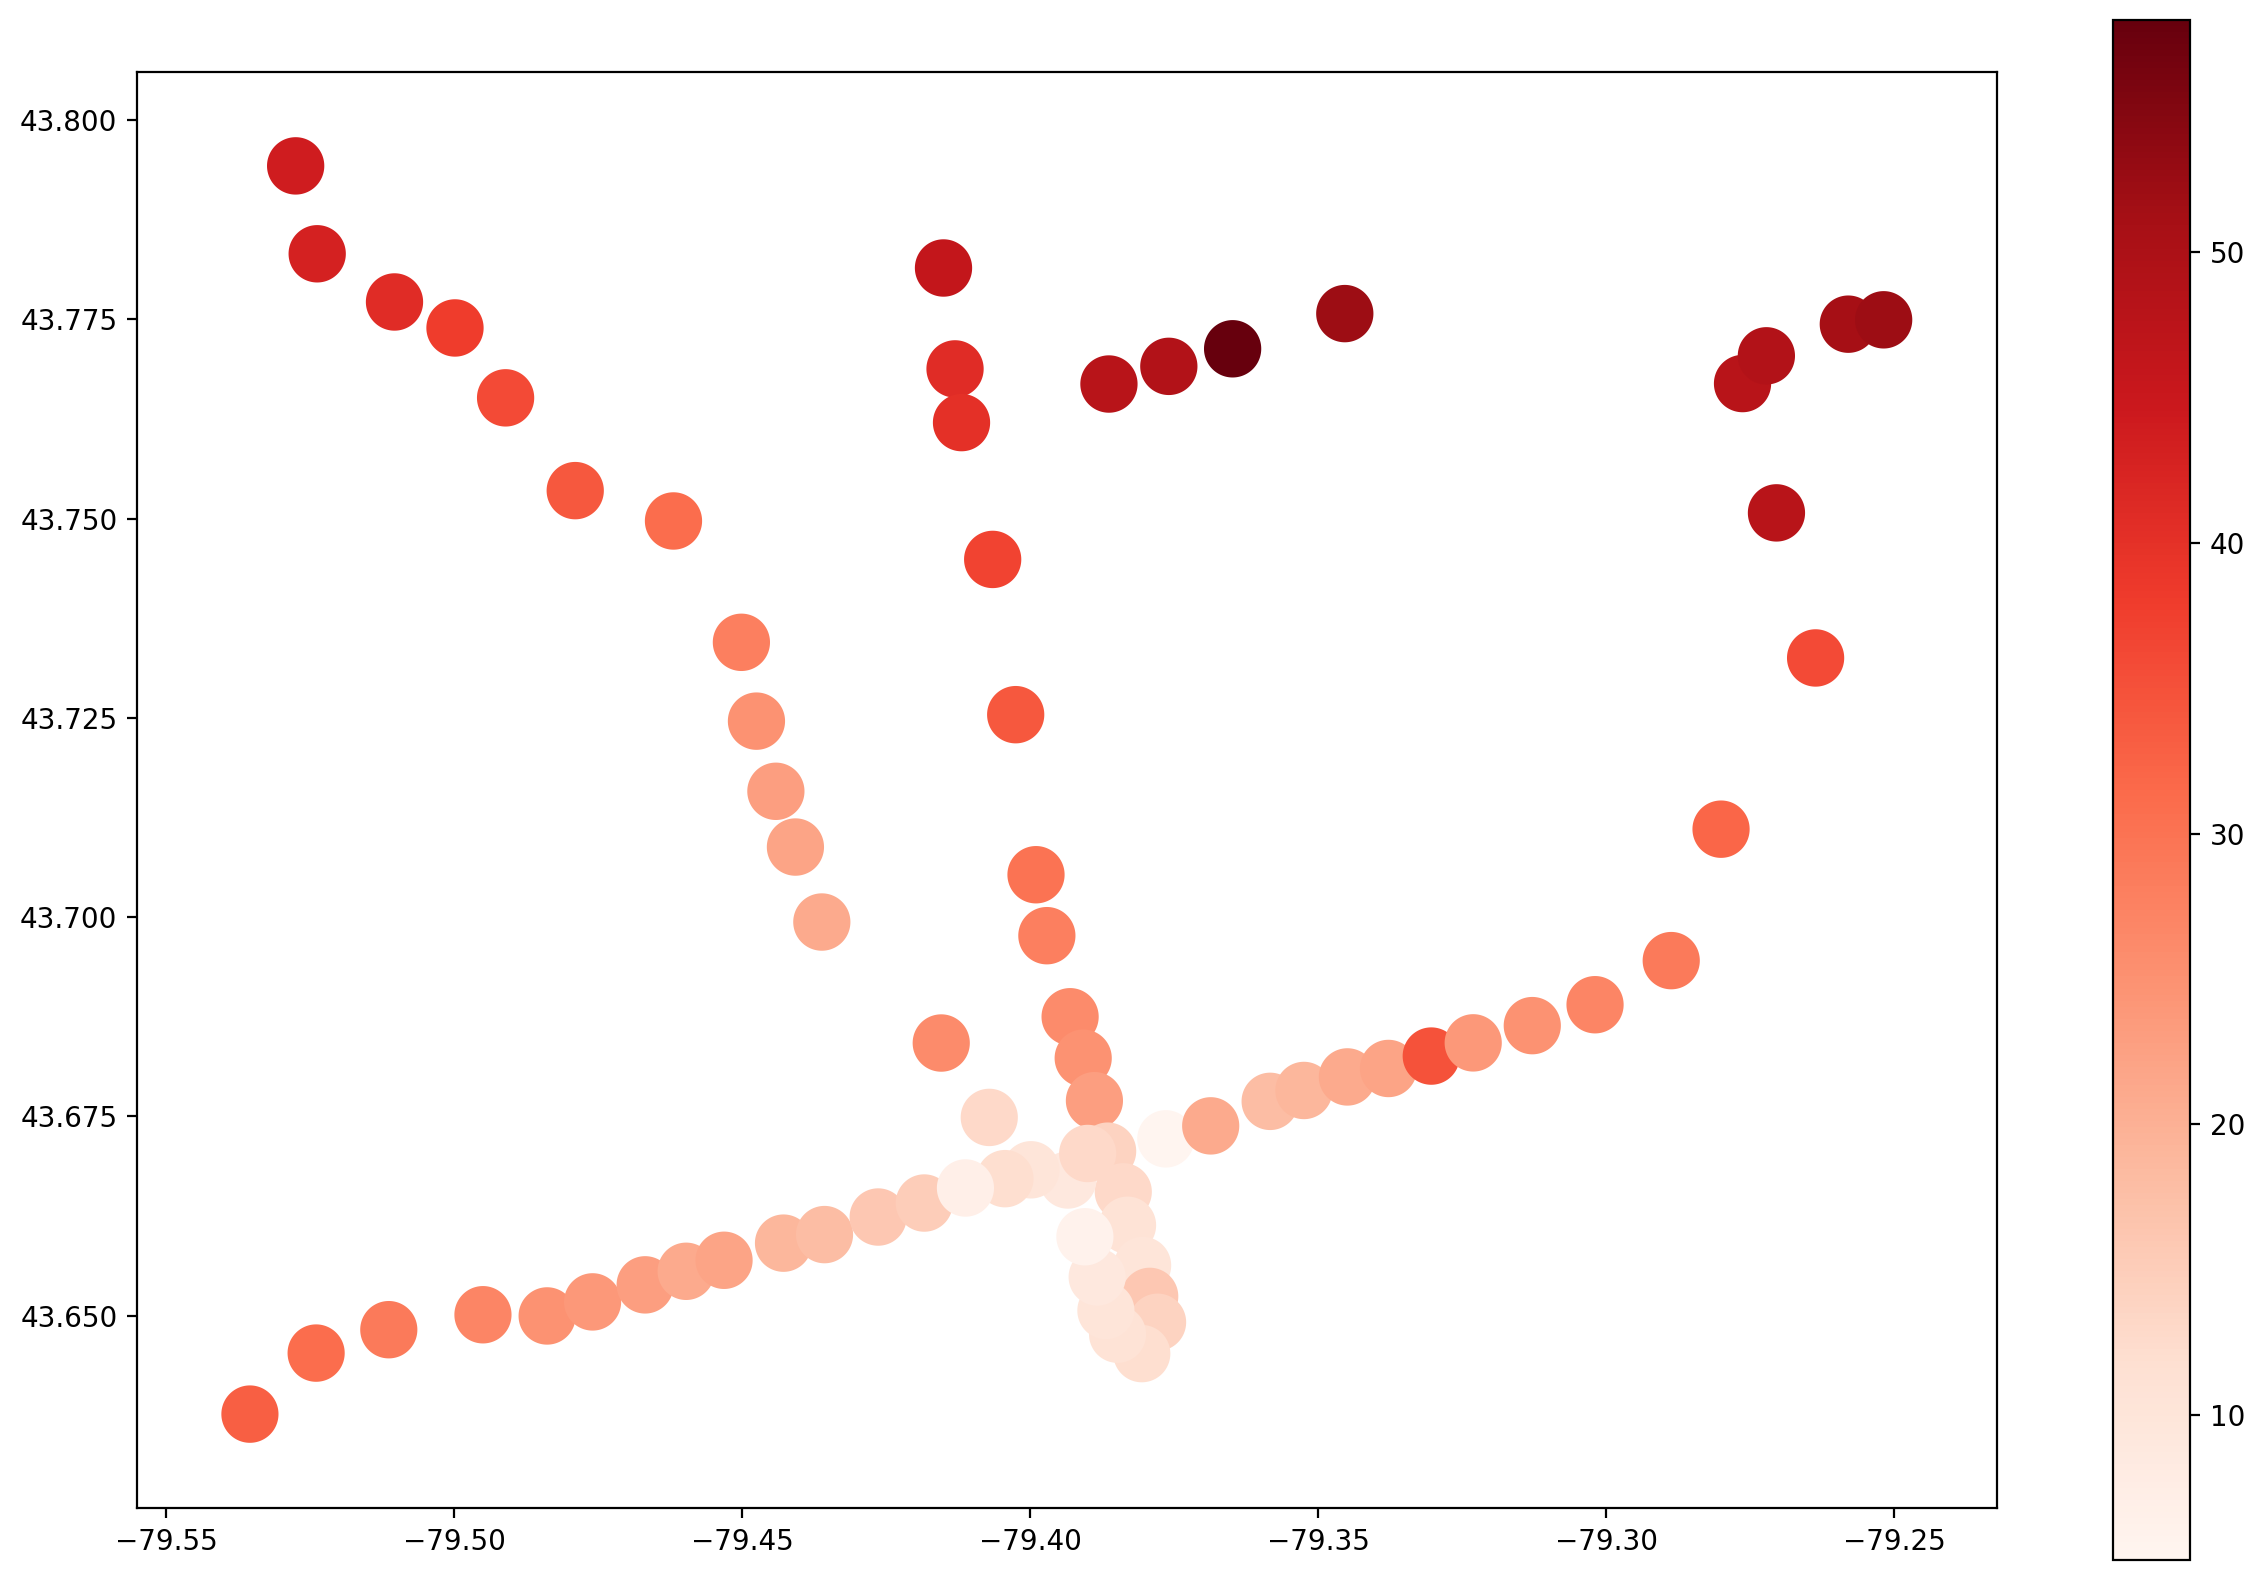

In [38]:
stations_area.plot(column = 'commute_time', cmap = 'Reds', legend = True)

In [39]:
# stations_point['destination'] = shapely.geometry.Point(destination[1], destination[0])
stations_point

,url,station,line,order,longitude,latitude,geometry
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,POINT (-79.41502 43.78143)
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,POINT (-79.41302 43.76877)
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,POINT (-79.41190 43.76203)
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,POINT (-79.40649 43.74487)
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,POINT (-79.40249 43.72539)
...,...,...,...,...,...,...,...
70,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931,POINT (-79.25182 43.77493)
71,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874,POINT (-79.38630 43.76687)
72,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092,POINT (-79.37591 43.76909)
73,https://www.ttc.ca/subway-stations/leslie-station,leslie,Line 4 Sheppard,2,-79.364835,43.771296,POINT (-79.36483 43.77130)


In [40]:
destination_df = gpd.GeoDataFrame(pd.DataFrame({'geometry' : [shapely.geometry.Point(destination[1], destination[0])]}),
                                  geometry='geometry',
                                  crs=epsg_3d)

destination_df

,geometry
0,POINT (-79.37877 43.64101)


In [41]:
destination_point = destination_df.to_crs(epsg_2d).iloc[0,0]

In [42]:
stations_area['distance_km'] = stations_point.to_crs(epsg_2d).geometry.distance(destination_point) / 10**3

In [43]:
stations_area

,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
0,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,"POLYGON ((-79.41005 43.78136, -79.41006 43.781...",46,15.869592
1,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,"POLYGON ((-79.40805 43.76870, -79.40805 43.768...",41,14.457603
2,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,"POLYGON ((-79.40693 43.76197, -79.40693 43.761...",40,13.706079
3,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,"POLYGON ((-79.40152 43.74480, -79.40152 43.744...",37,11.750787
4,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,"POLYGON ((-79.39753 43.72532, -79.39753 43.725...",34,9.565693
...,...,...,...,...,...,...,...,...,...
70,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931,"POLYGON ((-79.24685 43.77485, -79.24685 43.774...",52,18.054390
71,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874,"POLYGON ((-79.38134 43.76680, -79.38134 43.766...",48,13.994294
72,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092,"POLYGON ((-79.37094 43.76902, -79.37094 43.769...",49,14.229323
73,https://www.ttc.ca/subway-stations/leslie-station,leslie,Line 4 Sheppard,2,-79.364835,43.771296,"POLYGON ((-79.35987 43.77122, -79.35987 43.771...",58,14.515795


In [44]:
stations_area.sort_values(by = 'commute_time').head()

,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
53,https://www.ttc.ca/subway-stations/sherbourne-...,sherbourne,Line 2 Bloor-Danforth,15,-79.376431,43.672167,"POLYGON ((-79.37147 43.67210, -79.37147 43.672...",5,3.465659
20,https://www.ttc.ca/subway-stations/queens-park...,queens park,Line 1 Yonge-University,20,-79.390477,43.659880,"POLYGON ((-79.38552 43.65981, -79.38552 43.659...",6,2.298748
51,https://www.ttc.ca/subway-stations/bathurst-st...,bathurst,Line 2 Bloor-Danforth,13,-79.411215,43.666001,"POLYGON ((-79.40626 43.66593, -79.40626 43.665...",7,3.814924
21,https://www.ttc.ca/subway-stations/museum-station,museum,Line 1 Yonge-University,21,-79.393434,43.667006,"POLYGON ((-79.38847 43.66694, -79.38847 43.666...",9,3.120221
19,https://www.ttc.ca/subway-stations/st-patrick-...,st patrick,Line 1 Yonge-University,19,-79.388349,43.654831,"POLYGON ((-79.38339 43.65476, -79.38339 43.654...",9,1.718430


In [45]:
stations_area.sort_values(by = 'distance_km').head()

,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
16,https://www.ttc.ca/subway-stations/union-station,union,Line 1 Yonge-University,16,-79.380603,43.645221,"POLYGON ((-79.37565 43.64515, -79.37565 43.645...",12,0.490272
17,https://www.ttc.ca/subway-stations/st-andrew-s...,st andrew,Line 1 Yonge-University,17,-79.384808,43.647657,"POLYGON ((-79.37985 43.64759, -79.37985 43.647...",11,0.884350
15,https://www.ttc.ca/subway-stations/king-station,king,Line 1 Yonge-University,15,-79.377860,43.649152,"POLYGON ((-79.37290 43.64908, -79.37290 43.649...",14,0.906970
18,https://www.ttc.ca/subway-stations/osgoode-sta...,osgoode,Line 1 Yonge-University,18,-79.386831,43.650614,"POLYGON ((-79.38187 43.65054, -79.38187 43.650...",10,1.249196
14,https://www.ttc.ca/subway-stations/queen-station,queen,Line 1 Yonge-University,14,-79.379223,43.652397,"POLYGON ((-79.37426 43.65233, -79.37426 43.652...",16,1.264973


In [46]:
stations_area[stations_area.station == 'sherbourne']

,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
53,https://www.ttc.ca/subway-stations/sherbourne-...,sherbourne,Line 2 Bloor-Danforth,15,-79.376431,43.672167,"POLYGON ((-79.37147 43.67210, -79.37147 43.672...",5,3.465659


In [47]:
def get_column_order(df, column_name):
    temp_df = df.reset_index().sort_values(by = column_name).reset_index(drop = True).reset_index().set_index('index').sort_index()
    temp_df.rename(columns = {'level_0' : column_name + '_order'}, inplace = True)
    return temp_df

stations_area = get_column_order(stations_area, 'commute_time')
stations_area = get_column_order(stations_area, 'distance_km')


In [48]:
stations_area

,distance_km_order,commute_time_order,url,station,line,order,longitude,latitude,geometry,commute_time,distance_km
index,,,,,,,,,,,
0,65,65,https://www.ttc.ca/subway-stations/finch-station,finch,Line 1 Yonge-University,0,-79.415024,43.781433,"POLYGON ((-79.41005 43.78136, -79.41006 43.781...",46,15.869592
1,60,62,https://www.ttc.ca/subway-stations/north-york-...,north york centre,Line 1 Yonge-University,1,-79.413021,43.768769,"POLYGON ((-79.40805 43.76870, -79.40805 43.768...",41,14.457603
2,55,60,https://www.ttc.ca/subway-stations/sheppard-yo...,sheppard yonge,Line 1 Yonge-University,2,-79.411897,43.762035,"POLYGON ((-79.40693 43.76197, -79.40693 43.761...",40,13.706079
3,52,58,https://www.ttc.ca/subway-stations/york-mills-...,york mills,Line 1 Yonge-University,3,-79.406487,43.744867,"POLYGON ((-79.40152 43.74480, -79.40152 43.744...",37,11.750787
4,46,54,https://www.ttc.ca/subway-stations/lawrence-st...,lawrence,Line 1 Yonge-University,4,-79.402491,43.725387,"POLYGON ((-79.39753 43.72532, -79.39753 43.725...",34,9.565693
...,...,...,...,...,...,...,...,...,...,...,...
70,71,72,https://www.ttc.ca/subway-stations/mccowan-sta...,mccowan,Line 3 Scarborough,4,-79.251818,43.774931,"POLYGON ((-79.24685 43.77485, -79.24685 43.774...",52,18.054390
71,58,68,https://www.ttc.ca/subway-stations/bayview-sta...,bayview,Line 4 Sheppard,0,-79.386304,43.766874,"POLYGON ((-79.38134 43.76680, -79.38134 43.766...",48,13.994294
72,59,70,https://www.ttc.ca/subway-stations/bessarion-s...,bessarion,Line 4 Sheppard,1,-79.375908,43.769092,"POLYGON ((-79.37094 43.76902, -79.37094 43.769...",49,14.229323


In [49]:
# final check 
print(stations_area.line.unique())
print(len(stations_area.station.unique()))
print(stations_area.longitude.describe())
print(stations_area.latitude.describe())
print(stations_area.distance_km.describe())
print(stations_area.commute_time.describe())

['Line 1 Yonge-University' 'Line 2 Bloor-Danforth' 'Line 3 Scarborough'
 'Line 4 Sheppard']
75
count    75.000000
mean    -79.399217
std       0.068814
min     -79.535425
25%     -79.443461
50%     -79.393434
75%     -79.372273
max     -79.251818
Name: longitude, dtype: float64
count    75.000000
mean     43.699744
std       0.046988
min      43.637629
25%      43.660739
50%      43.682290
75%      43.747279
max      43.794244
Name: latitude, dtype: float64
count    75.000000
mean      8.561256
std       5.443355
min       0.490272
25%       4.085489
50%       7.325099
75%      13.734793
max      20.815697
Name: distance_km, dtype: float64
count    75.00000
mean     26.72000
std      13.20479
min       5.00000
25%      16.00000
50%      25.00000
75%      35.50000
max      58.00000
Name: commute_time, dtype: float64


In [50]:
stations_area.to_file('../data/processed/stations_area.geojson', driver='GeoJSON')

# More data sets
- https://open.toronto.ca/dataset/red-light-cameras/
- https://open.toronto.ca/dataset/automated-speed-enforcement-locations/
- https://open.toronto.ca/dataset/apartment-building-evaluation/
- https://open.toronto.ca/dataset/short-term-rentals-registration/
- https://open.toronto.ca/exploring-cleared-building-permits/
- https://housesigma.com/web/en/map?zoom=16.18&center=%7B%22lat%22%3A43.64309454129209,%22lng%22%3A-79.37652862520066%7D&list_type=%5B4%5D&id_listing=K8OgYBVrXBXYJmG2

# Improvement:

- include TTC bus and streetcar routes
- include GO train stations (only train not buses)
- expand to GTA area (Halton, Peel, York, Durham) + City of Toronto
- https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Greater_toronto_area_map.svg/1200px-Greater_toronto_area_map.svg.png
- include train schedule as commute time depends on departure time while being almost linear with distance